**Releases and Sales**
----------------------
An investigation of this dataset

In [1]:
# This R environment comes with all of CRAN preinstalled, as well as many other helpful packages
# The environment is defined by the kaggle/rstats docker image: https://github.com/kaggle/docker-rstats
# For example, here's several helpful packages to load in 

library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function
library(lattice)
library(scales)
library(reshape)
library(gridExtra)
library(corrgram)
library(randomForest)
library(tidyr)
library(caret)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

system("ls ../input")

# Any results you write to the current directory are saved as output.


Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘tidyr’

The following objects are masked from ‘package:reshape’:

    expand, smiths



In [2]:
sales = read.csv("../input/Video_Games_Sales_as_at_22_Dec_2016.csv", header=T, na.strings=c(""," ", "NA", "N/A"))

Data Overview
-------------

In [3]:
str(sales)
summary(sales)

'data.frame':	16719 obs. of  16 variables:
 $ Name           : Factor w/ 11562 levels " Beyblade Burst",..: 11058 9405 5571 11060 7410 9770 6692 11056 6695 2619 ...
 $ Platform       : Factor w/ 31 levels "2600","3DO","3DS",..: 26 12 26 26 6 6 5 26 26 12 ...
 $ Year_of_Release: int  2006 1985 2008 2009 1996 1989 2006 2006 2009 1984 ...
 $ Genre          : Factor w/ 12 levels "Action","Adventure",..: 11 5 7 11 8 6 5 4 5 9 ...
 $ Publisher      : Factor w/ 581 levels "10TACLE Studios",..: 370 370 370 370 370 370 370 370 370 370 ...
 $ NA_Sales       : num  41.4 29.1 15.7 15.6 11.3 ...
 $ EU_Sales       : num  28.96 3.58 12.76 10.93 8.89 ...
 $ JP_Sales       : num  3.77 6.81 3.79 3.28 10.22 ...
 $ Other_Sales    : num  8.45 0.77 3.29 2.95 1 0.58 2.88 2.84 2.24 0.47 ...
 $ Global_Sales   : num  82.5 40.2 35.5 32.8 31.4 ...
 $ Critic_Score   : int  76 NA 82 80 NA NA 89 58 87 NA ...
 $ Critic_Count   : int  51 NA 73 73 NA NA 65 41 80 NA ...
 $ User_Score     : Factor w/ 96 levels "0","0.2",

                          Name          Platform    Year_of_Release
 Need for Speed: Most Wanted:   12   PS2    :2161   Min.   :1980   
 FIFA 14                    :    9   DS     :2152   1st Qu.:2003   
 LEGO Marvel Super Heroes   :    9   PS3    :1331   Median :2007   
 Madden NFL 07              :    9   Wii    :1320   Mean   :2006   
 Ratatouille                :    9   X360   :1262   3rd Qu.:2010   
 (Other)                    :16669   PSP    :1209   Max.   :2020   
 NA's                       :    2   (Other):7284   NA's   :269    
          Genre                             Publisher        NA_Sales      
 Action      :3370   Electronic Arts             : 1356   Min.   : 0.0000  
 Sports      :2348   Activision                  :  985   1st Qu.: 0.0000  
 Misc        :1750   Namco Bandai Games          :  939   Median : 0.0800  
 Role-Playing:1500   Ubisoft                     :  933   Mean   : 0.2633  
 Shooter     :1323   Konami Digital Entertainment:  834   3rd Qu.: 0.2400  


Data Preparation
--------------------

'tbd' and 'K-A' are simply NA and 'E' respectively. 
The Titles which cannot be released right now are dropped. Ordinal Values for Rating for possible numeric usecases.

In [4]:
sales$User_Score[sales$User_Score == 'tbd' & !is.na(sales$User_Score)] <- NA
sales$User_Score <- as.numeric(as.character(sales$User_Score))
sales <- sales[ !( sales$Year_of_Release > 2017 | is.na(sales$Year_of_Release)),]
sales$Rating[sales$Rating == 'K-A' & !is.na(sales$Rating) ] <- 'E'
sales$Rating[sales$Rating == 'RP' & !is.na(sales$Rating) ] <- NA
sales$Ratingn <- as.numeric(as.character(factor(sales$Rating, levels =c("RP", "EC", "E" ,"E10+", "T", "M","AO"), labels = c(NA,1,2,3,4,5,6))))

Correlation Plot
----------------

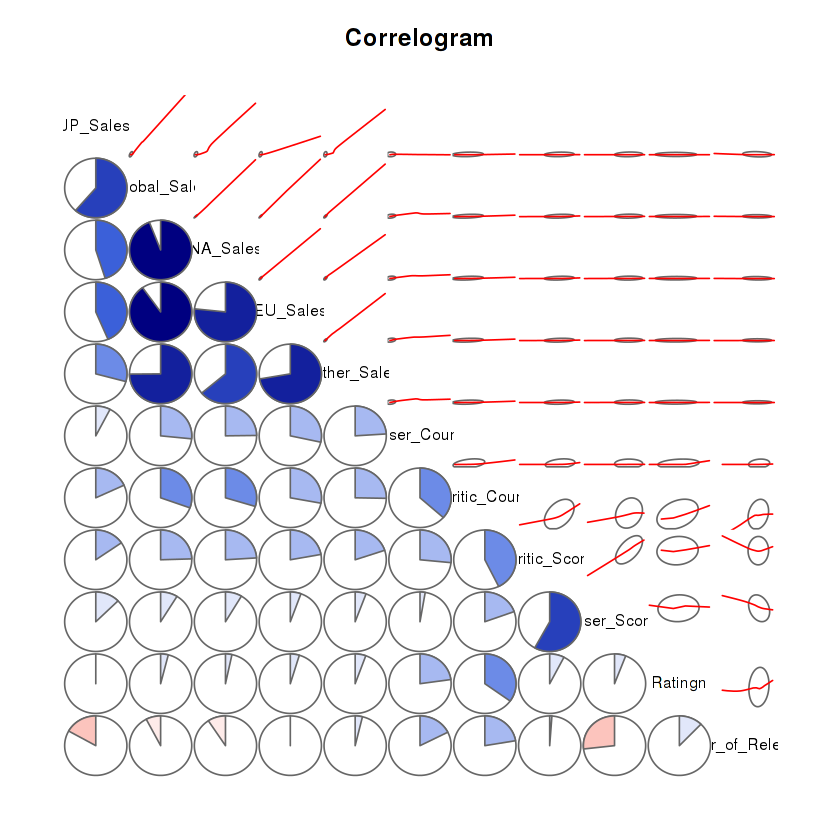

In [5]:

#z <- cor(sales[,sapply(sales, is.numeric)], use="complete")
#levelplot(z,scales=list(x=list(rot=30)))

corrgram(sales[,sapply(sales, is.numeric)], order=TRUE, lower.panel=panel.pie,
                upper.panel=panel.ellipse, text.panel=panel.txt,
                main="Correlogram")

Not that interesting right now.

Some Definitions
----------------

At first, list the available platforms

In [6]:
levels(sales$Platform)

[1] "2600" "3DO"  "3DS"  "DC"   "DS"   "GB"   "GBA"  "GC"   "GEN"  "GG"  
[11] "N64"  "NES"  "NG"   "PC"   "PCFX" "PS"   "PS2"  "PS3"  "PS4"  "PSP" 
[21] "PSV"  "SAT"  "SCD"  "SNES" "TG16" "Wii"  "WiiU" "WS"   "X360" "XB"  
[31] "XOne"

Defining the relevant vectors

In [7]:
nintendoplatforms = c("3DS","DS","GB","GBA","N64","GC", "NES","SNES","Wii","WiiU")
sonyplatforms = c("PS","PS2","PSP","PS3","PS4","PSV")
segaplatforms = c("GEN","SCD","DC","GG")
msplatforms = c("XB","X360", "XOne")
otherplatforms = c("2006","3DO","NG","PCFX","TG16")
fourthgen = c("SNES", "GEN")
fifthgen = c("N64", "SAT","PS")
sixthgen = c("PS2", "GC","DC","XB")
seventhgen= c("Wii","X360","PS3")

Global Sales by Platform Vendor
------------

Assigning the platform vendor to every title.

In [8]:
sales$Platformvendor[sales$Platform %in% nintendoplatforms] <- "nintendo"
sales$Platformvendor[sales$Platform %in% sonyplatforms] <- "sony"
sales$Platformvendor[sales$Platform %in% msplatforms] <- "microsoft"
sales$Platformvendor[sales$Platform %in% segaplatforms] <- "sega"
sales$Platformvendor[sales$Platform == "PC"] <- "comp"
sales$Platformvendor[is.na(sales$Platformvendor)] <- "other"

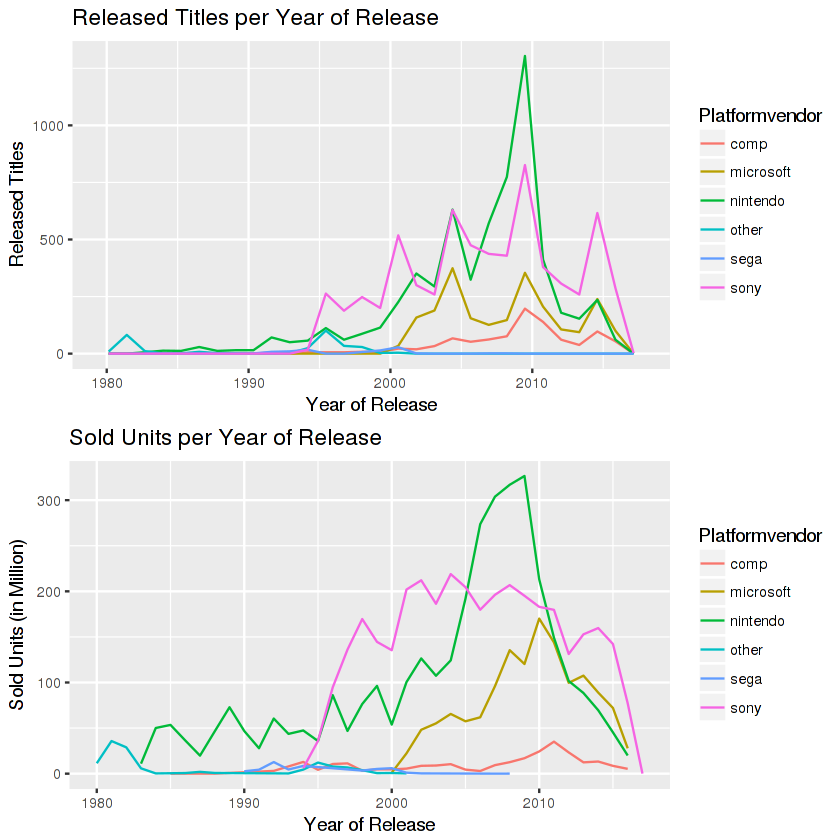

In [9]:
temp1 <- ggplot(sales, aes(x=Year_of_Release)) + 
geom_line(aes(y=..count.., color=Platformvendor), stat="bin", bins = 30) + 
ggtitle("Released Titles per Year of Release") +
xlab("Year of Release") + ylab("Released Titles")

temp2 <-ggplot(aggregate(Global_Sales~Platformvendor + Year_of_Release, data=sales, FUN=sum), aes(x=Year_of_Release)) + 
geom_line(aes(y=Global_Sales, color=Platformvendor)) + 
ggtitle("Sold Units per Year of Release") +
xlab("Year of Release") + ylab("Sold Units (in Million)")

grid.arrange(temp1,temp2, ncol=1)

You can actually see, when new platforms were released by their vendors.
Of course, newer games didn't have the time to perform well. 

Global Sales per 4th, 5th, 6th and 7th generation by platform
------------

In [10]:
soltbyplatform <- aggregate(Global_Sales~Platform + Year_of_Release, data=sales, FUN=sum)

fogr <- ggplot(sales[sales$Platform %in% fourthgen,], aes(Year_of_Release)) + 
geom_histogram(aes(fill = Platform), position="dodge", binwidth=0.5) + 
ggtitle("Released Titles in the Fourth Generation of Video Game Consoles") +
xlab("Year") + ylab("Released Titles")

figr <-ggplot(sales[sales$Platform %in% fifthgen,], aes(Year_of_Release)) + 
geom_histogram(aes(fill = Platform), position="dodge", binwidth=0.5) +
ggtitle("Released Titles in the Fifth Generation of Video Game Consoles") + 
xlab("Year") + ylab("Released Titles")

sigr <-ggplot(sales[sales$Platform %in% sixthgen,], aes(Year_of_Release)) + 
geom_histogram(aes(fill = Platform), position="dodge", binwidth=0.5) + 
ggtitle("Released Titles in the Sixth Generation of Video Game Consoles") +
xlab("Year") + ylab("Released Titles")

segr <-ggplot(sales[sales$Platform %in% seventhgen,], aes(Year_of_Release)) + 
geom_histogram(aes(fill = Platform), position="dodge", binwidth=0.5) + 
ggtitle("Released Titles in the Seventh Generation of Video Game Consoles") +
xlab("Year") + ylab("Released Titles")

fogs <- ggplot(soltbyplatform[soltbyplatform$Platform %in% fourthgen,], aes(x=Year_of_Release, y=Global_Sales, fill=Platform)) + 
geom_bar(aes(),stat = "identity", position="dodge") +
ggtitle("Sold Units in the Fourth Generation of Video Game Consoles") + 
xlab("Year") + ylab("Sold Units")

figs <- ggplot(soltbyplatform[soltbyplatform$Platform %in% fifthgen,], aes(x=Year_of_Release, y=Global_Sales, fill=Platform)) + 
geom_bar(aes(),stat = "identity", position="dodge") + 
ggtitle("Sold Units in the Fifth Generation of Video Game Consoles") +
xlab("Year") + ylab("Sold Units")

sigs <- ggplot(soltbyplatform[soltbyplatform$Platform %in% sixthgen,], aes(x=Year_of_Release, y=Global_Sales, fill=Platform)) + 
geom_bar(aes(),stat = "identity", position="dodge") + 
ggtitle("Sold Units in the Sixth Generation of Video Game Consoles") +
xlab("Year") + ylab("Sold Units")

segs <- ggplot(soltbyplatform[soltbyplatform$Platform %in% seventhgen,], aes(x=Year_of_Release, y=Global_Sales, fill=Platform)) + 
geom_bar(aes(),stat = "identity", position="dodge") + 
ggtitle("Sold Units in the Seventh Generation of Video Game Consoles") +
xlab("Year") + ylab("Sold Units")

On the left side, there are the released titles of the fourth, fifth and sixth generation by platform.  
On the right side, there are the total sold units of titles assigned to the the year of the title's release respectively.  
The dataset may not resemble the actual situation here. E.g. the Genesis only has so few titles compared to the SNES.
Showing only what the datset gives us

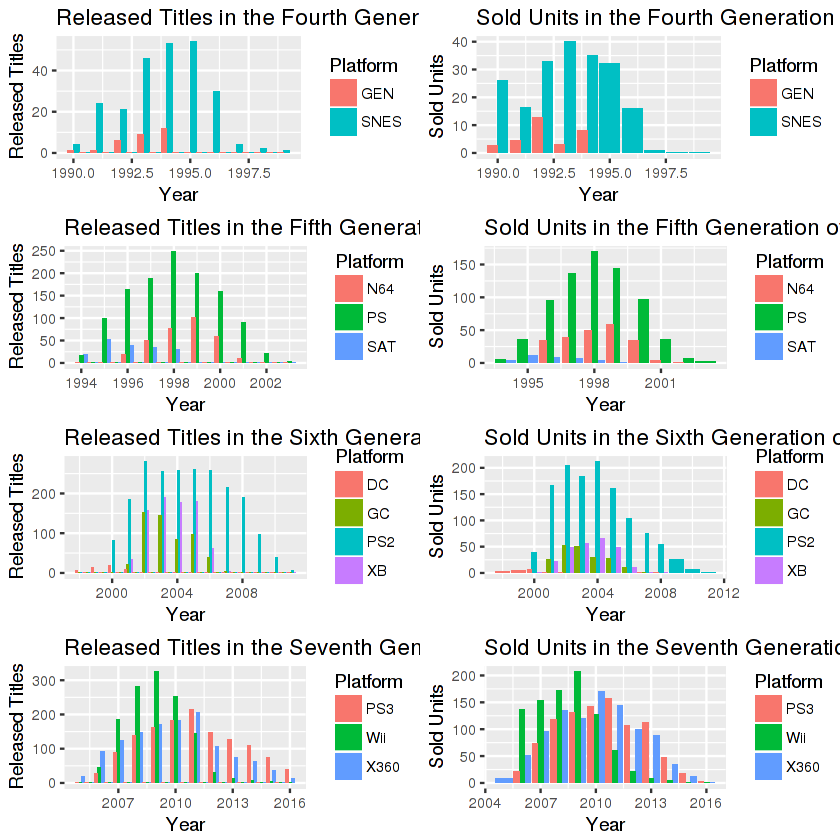

In [11]:
grid.arrange(fogr,fogs,figr,figs,sigr,sigs,segr,segs, ncol=2)

The PS2 has a much better sales count per title than the competitors of the 6th generation.  
Also, the Wii had a high efficency on a per title basis by its release, but it decreased rapidly compared to its competitors.

Investigation of Global Sales by platform
---------------------------------------------------

**Top 10 Mean of sales per title by platform, sorted by the mean of global sales**

In [12]:
meanplatformsale <- aggregate(cbind(Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales)~Platform, data=sales, FUN=mean)
meanplatformsale <- meanplatformsale[order(-meanplatformsale$Global_Sales),]
head(meanplatformsale, n=10)

,Platform,Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales
6,GB,2.6228866,0.48979381,1.1715464,0.877525773,0.084123711
12,NES,2.5619388,0.21581633,1.2851020,1.006632653,0.054183673
9,GEN,1.0613793,0.20862069,0.7258621,0.093103448,0.033448276
24,SNES,0.8370293,0.07966527,0.2561925,0.487656904,0.013472803
19,PS4,0.7995674,0.35900763,0.2766921,0.040712468,0.123027990
29,X360,0.7803490,0.21779221,0.4835552,0.009983766,0.068896104
1,2600,0.7462931,0.04189655,0.6963793,0.000000000,0.007241379
18,PS3,0.7129786,0.25054364,0.2987213,0.060803982,0.103055130
26,Wii,0.6934215,0.20087092,0.3785925,0.053094868,0.060427683
11,N64,0.6905380,0.12984177,0.4395886,0.106835443,0.013639241


**Top 10 Sum of sales by platform, sorted by the sum of global sales**

In [13]:
sumplatformsale <- aggregate(cbind(Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales)~Platform, data=sales, FUN=sum)
sumplatformsale <- sumplatformsale[order(-sumplatformsale$Global_Sales),]
head(sumplatformsale, n=10)

,Platform,Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales
17,PS2,1233.46,332.63,572.92,137.54,190.47
29,X360,961.39,268.32,595.74,12.30,84.88
18,PS3,931.15,327.21,390.13,79.41,134.59
26,Wii,891.74,258.32,486.87,68.28,77.71
5,DS,803.44,188.41,380.31,175.02,59.04
16,PS,727.41,212.39,334.72,139.78,40.69
19,PS4,314.23,141.09,108.74,16.00,48.35
7,GBA,313.56,74.59,184.12,46.56,7.61
20,PSP,289.79,65.62,107.27,75.88,40.76
3,3DS,257.92,61.27,82.65,100.62,13.27


Gameboy titles give us the best average result, whereas PS2 titles were sold the most.

**Number of Titles and standard deviation of global sales by platform**

In [14]:
temp1 <- aggregate(Global_Sales~Platform, data=sales, FUN=length)
temp2 <- aggregate(Global_Sales~Platform, data=sales, FUN=sd)

colnames(temp1)[2] <- "number of titles"
colnames(temp2)[2] <- "SD of Global Sales"

temp3 <- merge(temp1,temp2, id="Platform")
temp3[order(-temp3[2]),]

,Platform,number of titles,SD of Global Sales
17,PS2,2127,1.13855795
5,DS,2121,1.43610896
18,PS3,1306,1.40287939
26,Wii,1286,3.16478588
29,X360,1232,1.63182498
20,PSP,1193,0.52201742
16,PS,1190,1.05669295
14,PC,957,0.67970490
7,GBA,811,0.89929816
30,XB,803,0.53885832


The NES and the GB are the kings of deviation but also have so few titles. 
Well, at least we can see that the deviaton of the Wii is much higher than the deviation of the X360 and PS3.

Investigation of Global Sales by Genre
---------------------------------------------------

**Mean of sales by genre, sorted by the mean of global sales**

In [15]:
meangenresale <- aggregate(cbind(Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales)~Genre, data=sales, FUN=mean)
meangenresale <- meangenresale[order(-meangenresale$Global_Sales),]
head(meangenresale, n=12)

,Genre,Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales
5,Platform,0.9406150,0.22709567,0.50619590,0.14887244,0.05809795
9,Shooter,0.8038812,0.24268519,0.45125772,0.02984568,0.07972994
8,Role-Playing,0.6277141,0.12693189,0.22254889,0.23832771,0.04006069
7,Racing,0.5902936,0.19126427,0.29107667,0.04619086,0.06159054
11,Sports,0.5682524,0.16102775,0.29106678,0.05851258,0.05733304
3,Fighting,0.5288292,0.11827957,0.26345281,0.10427718,0.04285544
1,Action,0.5192352,0.15447098,0.26093410,0.04841294,0.05508464
4,Misc,0.4595816,0.12237071,0.23217316,0.06218478,0.04247531
10,Simulation,0.4528705,0.13226371,0.21050175,0.07425904,0.03567095
6,Puzzle,0.4223726,0.08748682,0.21288225,0.09961336,0.02161687


**Sum of sales by genre, sorted by sum of global sales**

In [16]:
sumgenresale <- aggregate(cbind(Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales)~Genre, data=sales, FUN=sum)
sumgenresale <- sumgenresale[order(-sumgenresale$Global_Sales),]
head(sumgenresale, n=12)

,Genre,Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales
1,Action,1717.63,510.99,863.17,160.15,182.22
11,Sports,1310.39,371.33,671.20,134.93,132.21
9,Shooter,1041.83,314.52,584.83,38.68,103.33
8,Role-Playing,930.90,188.24,330.04,353.44,59.41
5,Platform,825.86,199.39,444.44,130.71,51.01
4,Misc,790.94,210.60,399.57,107.02,73.10
7,Racing,723.70,234.49,356.86,56.63,75.51
3,Fighting,442.63,99.00,220.51,87.28,35.87
10,Simulation,388.11,113.35,180.40,63.64,30.57
6,Puzzle,240.33,49.78,121.13,56.68,12.30


Platform games give us the best average result, whereas action games were sold the most, at least in this dataset

**number of titles and standard deviation of global sales by genre**

In [17]:
temp1 <- aggregate(Global_Sales~Genre, data=sales, FUN=length)
temp2 <- aggregate(Global_Sales~Genre, data=sales, FUN=sd)

colnames(temp1)[2] <- "number of titles"
colnames(temp2)[2] <- "SD of Global Sales"

temp3 <- merge(temp1,temp2, id="Genre")
temp3[order(-temp3[2]),]

,Genre,number of titles,SD of Global Sales
1,Action,3308,1.1535654
11,Sports,2306,2.0995978
4,Misc,1721,1.3129000
8,Role-Playing,1483,1.7182147
9,Shooter,1296,1.8315427
2,Adventure,1293,0.5054228
7,Racing,1226,1.6708653
5,Platform,878,2.5874935
10,Simulation,857,1.1968766
3,Fighting,837,0.9541694


Platform games do also have the highest deviation.

Investigation of Global Sales Rating
---------------------------------------------------
Right now im ignoring the fact, that the ESRB Rating relates to the USA.  

**Mean of sales by rating, sorted by the mean of global sales**

In [18]:
meanratingsale <- aggregate(cbind(Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales)~Rating, data=sales, FUN=mean)
meanratingsale <- meanratingsale[order(-meanratingsale$Global_Sales),]
head(meanratingsale, n=10)

,Rating,Global_Sales,EU_Sales,NA_Sales,JP_Sales,Other_Sales
1,AO,1.9500000,0.6100000,1.2600000,0.00000000,0.09000000
5,M,0.9522135,0.3125000,0.4836523,0.04139323,0.11462240
2,E,0.6149337,0.1794444,0.3253823,0.05082059,0.05901376
6,T,0.5074458,0.1451945,0.2573494,0.05187608,0.05266437
3,E10+,0.4603015,0.1316224,0.2480258,0.02885858,0.05163676
4,EC,0.2225000,0.0137500,0.1912500,0.00000000,0.01375000


Adults Only games perform best    
The Order for Global_Sales, NA_Sales and EU_Sales are the same.  

**number of titles and standard deviation of global sales by rating**  

Let us have a look on the standard deviation here.

In [19]:
temp1 <- aggregate(Global_Sales~Rating, data=sales, FUN=length)
temp2 <- aggregate(Global_Sales~Rating, data=sales, FUN=sd)

colnames(temp1)[2] <- "number of titles"
colnames(temp2)[2] <- "SD of Global Sales"

temp3 <- merge(temp1,temp2, id="Rating")
temp3[order(-temp3[2]),]

,Rating,number of titles,SD of Global Sales
2,E,3924,2.1444741
6,T,2905,0.9145742
5,M,1536,1.9417434
3,E10+,1393,0.7979799
4,EC,8,0.1473334
1,AO,1,NA


Aah. Not much to learn from here. M seems to deviate more than E10+ Titles. 
Also E deviates more than T.

preliminary result
------------------

The dataset is not reliable as of now. 
Guesstimation: The best subset of this dataset would be the seventh generation of home consoles.  DS vs PSP may also be fine.
Also 0 sales should be considered NA. The Median of JP Sales is even 0. So using only NA_Sales and maybe EU_Sales sales may give us some more insight.

In [20]:
sales <- sales[(sales$Platform %in% seventhgen), 
               !(names(sales) %in% c("Other_Sales", "Global_Sales", "JP_Sales", "EU_Sales" ) )]
sales[sales$NA_Sales == 0,] <- NA
sales <- sales[complete.cases(sales),]
sales$Platform <- factor(sales$Platform)
sales$Developer <- factor(sales$Developer)
sales$Name <- factor(sales$Name)

Adding First Party Publishers to the dataset

In [21]:
sonypublishers <- c("Sony Computer Entertainment","Sony Computer Entertainment America",
                                                            "Sony Computer Entertainment Europe",
                                                            "Sony Music Entertainment",
                                                            "Sony Online Entertainment")
sales$FP <- FALSE
sales$FP[(sales$Publisher %in% sonypublishers) & (sales$Platform == "PS3")] <- TRUE
sales$FP[(sales$Publisher %in% 'Microsoft Game Studios') & (sales$Platform %in% 'X360')] <- TRUE
sales$FP[(sales$Publisher %in% "Nintendo") & (sales$Platform %in% "Wii")] <- TRUE

Adding First party developers to the dataset

In [22]:
sonydevs <- c('Sony Online Entertainment', 'Polyphony Digital','SCE Japan Studio',
              'SCE Santa Monica','SCE Studio Cambridge','SCE/WWS, Media Molecule',
              'SCEA San Diego Studios','SCEA','SCEA, Zindagi Games', 'SCEE',
              'SCEE London Studio','SCEJ','Guerrilla')
cat ("Not finished")
head(sales,15)

Not finished

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Ratingn,Platformvendor,FP
1,Wii Sports,Wii,2006,Sports,Nintendo,41.36,76,51,8.0,322,Nintendo,E,2,nintendo,TRUE
3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,82,73,8.3,709,Nintendo,E,2,nintendo,TRUE
4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,80,73,8.0,192,Nintendo,E,2,nintendo,TRUE
8,Wii Play,Wii,2006,Misc,Nintendo,13.96,58,41,6.6,129,Nintendo,E,2,nintendo,TRUE
9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.44,87,80,8.4,594,Nintendo,E,2,nintendo,TRUE
14,Wii Fit,Wii,2007,Sports,Nintendo,8.92,80,63,7.7,146,Nintendo,E,2,nintendo,TRUE
15,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,15.00,61,45,6.3,106,Good Science Studio,E,2,microsoft,TRUE
16,Wii Fit Plus,Wii,2009,Sports,Nintendo,9.01,80,33,7.4,52,Nintendo,E,2,nintendo,TRUE
17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.02,97,50,8.2,3994,Rockstar North,M,5,sony,FALSE
24,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.66,97,58,8.1,3711,Rockstar North,M,5,microsoft,FALSE


Building Models for the 7th generation
--------------------------------------

We want to see which variable is the most importent for the North American Sales of a platform.
We will build a log-linear model and a random forest for each platform.

Splitting in test and train data
----------------------------

In [23]:
set.seed(123)
ps3set <- subset(sales, Platform=="PS3")
index <- sample(1:nrow(ps3set),size = 0.7*nrow(ps3set)) 
ps3set.train <- ps3set[index,]
ps3set.test <- ps3set[-index,]
nrow(ps3set.train)

[1] 518

In [24]:
wiiset <- subset(sales, Platform=="Wii")
index <- sample(1:nrow(wiiset),size = 0.7 * nrow(wiiset)) 
wiiset.train <- wiiset[index,]
wiiset.test <- wiiset[-index,]
nrow(wiiset.train)

[1] 335

In [25]:
x360set <- subset(sales, Platform=="X360")
index <- sample(1:nrow(x360set),size = 0.7 * nrow(x360set)) 
x360set.train <- x360set[index,]
x360set.test <- x360set[-index,]
nrow(x360set.train)

[1] 595

Building log linear models
----------------------------
Linear models will be reevaluated after the first build

In [26]:
ps3.lm <- lm(formula= log(NA_Sales+1) ~ Ratingn + User_Count +
            User_Score + Critic_Count + Critic_Score + FP +
            Year_of_Release, data=ps3set.train)
summary(ps3.lm)


Call:
lm(formula = log(NA_Sales + 1) ~ Ratingn + User_Count + User_Score + 
    Critic_Count + Critic_Score + FP + Year_of_Release, data = ps3set.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02074 -0.12558 -0.03293  0.07747  1.20199 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.452e+01  9.228e+00   4.824 1.86e-06 ***
Ratingn         -1.220e-04  9.736e-03  -0.013  0.99000    
User_Count       2.201e-04  1.713e-05  12.851  < 2e-16 ***
User_Score      -4.063e-02  8.875e-03  -4.578 5.91e-06 ***
Critic_Count     2.110e-03  6.491e-04   3.251  0.00122 ** 
Critic_Score     1.028e-02  9.524e-04  10.796  < 2e-16 ***
FPTRUE           4.233e-03  3.650e-02   0.116  0.90772    
Year_of_Release -2.228e-02  4.593e-03  -4.851 1.64e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2091 on 510 degrees of freedom
Multiple R-squared:  0.5726,	Adjusted R-squared:  0.5667 
F-statistic:

In [27]:
ps3.lm <- lm(formula= log(NA_Sales+1) ~ User_Count +
            User_Score + Critic_Count + Critic_Score +
            Year_of_Release, data=ps3set.train)
summary(ps3.lm)


Call:
lm(formula = log(NA_Sales + 1) ~ User_Count + User_Score + Critic_Count + 
    Critic_Score + Year_of_Release, data = ps3set.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.01944 -0.12512 -0.03279  0.07857  1.20086 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.456e+01  9.104e+00   4.894 1.33e-06 ***
User_Count       2.203e-04  1.662e-05  13.253  < 2e-16 ***
User_Score      -4.060e-02  8.634e-03  -4.703 3.31e-06 ***
Critic_Count     2.132e-03  5.804e-04   3.673 0.000265 ***
Critic_Score     1.028e-02  8.830e-04  11.644  < 2e-16 ***
Year_of_Release -2.230e-02  4.529e-03  -4.924 1.14e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2087 on 512 degrees of freedom
Multiple R-squared:  0.5726,	Adjusted R-squared:  0.5684 
F-statistic: 137.2 on 5 and 512 DF,  p-value: < 2.2e-16


In [28]:
wii.lm <- lm(formula= log(NA_Sales+1) ~ Ratingn + User_Count +
            User_Score + Critic_Count + Critic_Score + FP +
            Year_of_Release, data=wiiset.train)
summary(wii.lm)


Call:
lm(formula = log(NA_Sales + 1) ~ Ratingn + User_Count + User_Score + 
    Critic_Count + Critic_Score + FP + Year_of_Release, data = wiiset.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79839 -0.18311 -0.05302  0.08383  2.75232 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.977e+01  2.978e+01   1.671 0.095611 .  
Ratingn         -8.113e-02  2.179e-02  -3.723 0.000232 ***
User_Count       5.433e-04  1.043e-04   5.210 3.35e-07 ***
User_Score      -7.902e-03  1.738e-02  -0.455 0.649730    
Critic_Count     2.487e-05  1.597e-03   0.016 0.987589    
Critic_Score     5.555e-03  2.024e-03   2.745 0.006389 ** 
FPTRUE           3.438e-01  7.566e-02   4.544 7.77e-06 ***
Year_of_Release -2.467e-02  1.484e-02  -1.663 0.097360 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3637 on 327 degrees of freedom
Multiple R-squared:  0.3442,	Adjusted R-squared:  0.3301 
F-statistic:

In [29]:
wii.lm <- lm(formula= log(NA_Sales+1) ~ Ratingn + User_Count + FP + Year_of_Release +
             Critic_Score, data=wiiset.train)
summary(wii.lm)


Call:
lm(formula = log(NA_Sales + 1) ~ Ratingn + User_Count + FP + 
    Year_of_Release + Critic_Score, data = wiiset.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79976 -0.19225 -0.05510  0.08621  2.75193 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.858e+01  2.905e+01   1.672 0.095433 .  
Ratingn         -8.212e-02  2.149e-02  -3.821 0.000159 ***
User_Count       5.481e-04  9.796e-05   5.595 4.64e-08 ***
FPTRUE           3.422e-01  6.955e-02   4.920 1.37e-06 ***
Year_of_Release -2.409e-02  1.448e-02  -1.664 0.097120 .  
Critic_Score     4.971e-03  1.474e-03   3.372 0.000835 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3627 on 329 degrees of freedom
Multiple R-squared:  0.3438,	Adjusted R-squared:  0.3338 
F-statistic: 34.47 on 5 and 329 DF,  p-value: < 2.2e-16


In [30]:
x360.lm <- lm(formula= log(NA_Sales+1) ~ Ratingn + User_Count + FP +
            User_Score + Critic_Count + Critic_Score +
            Year_of_Release, data=x360set.train)
summary(x360.lm)


Call:
lm(formula = log(NA_Sales + 1) ~ Ratingn + User_Count + FP + 
    User_Score + Critic_Count + Critic_Score + Year_of_Release, 
    data = x360set.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.37450 -0.15670 -0.03734  0.08730  2.19851 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -1.246e+01  1.115e+01  -1.117  0.26434    
Ratingn         -3.986e-02  1.244e-02  -3.204  0.00143 ** 
User_Count       3.557e-04  2.347e-05  15.151  < 2e-16 ***
FPTRUE           2.125e-01  5.009e-02   4.242 2.57e-05 ***
User_Score      -1.834e-02  1.099e-02  -1.669  0.09570 .  
Critic_Count     4.045e-03  7.610e-04   5.315 1.52e-07 ***
Critic_Score     6.403e-03  1.239e-03   5.167 3.26e-07 ***
Year_of_Release  6.171e-03  5.551e-03   1.112  0.26679    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2769 on 587 degrees of freedom
Multiple R-squared:  0.5517,	Adjusted R-squared:  0.5463 
F-stat

In [31]:
x360.lm <- lm(formula= log(NA_Sales+1) ~ Ratingn + User_Count + FP +
            User_Score + Critic_Count + Critic_Score, data=x360set.train)
summary(x360.lm)


Call:
lm(formula = log(NA_Sales + 1) ~ Ratingn + User_Count + FP + 
    User_Score + Critic_Count + Critic_Score, data = x360set.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.39132 -0.15729 -0.03810  0.07994  2.21135 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.422e-02  7.727e-02  -0.831  0.40625    
Ratingn      -3.670e-02  1.212e-02  -3.029  0.00256 ** 
User_Count    3.575e-04  2.342e-05  15.268  < 2e-16 ***
FPTRUE        2.103e-01  5.006e-02   4.200 3.08e-05 ***
User_Score   -2.088e-02  1.076e-02  -1.942  0.05263 .  
Critic_Count  3.813e-03  7.320e-04   5.209 2.64e-07 ***
Critic_Score  6.733e-03  1.203e-03   5.595 3.39e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.277 on 588 degrees of freedom
Multiple R-squared:  0.5507,	Adjusted R-squared:  0.5461 
F-statistic: 120.1 on 6 and 588 DF,  p-value: < 2.2e-16


Building Importance tables for linear models

In [32]:
ps3.lmimp <- varImp(ps3.lm)
wii.lmimp <- varImp(wii.lm)
x360.lmimp <- varImp(x360.lm)
ps3.lmimp <- ps3.lmimp[order(-ps3.lmimp$Overall),, drop=FALSE]
wii.lmimp <- wii.lmimp[order(-wii.lmimp$Overall),, drop=FALSE]
x360.lmimp <- x360.lmimp[order(-x360.lmimp$Overall),, drop=FALSE]

Predicting Values

In [33]:
ps3set.test.predlm <- exp(predict(ps3.lm,ps3set.test))-1
wiiset.test.predlm <- exp(predict(wii.lm,wiiset.test))-1
x360set.test.predlm <- exp(predict(x360.lm,x360set.test))-1

Building Random Forests
------------------------

In [34]:
ps3.rf <- randomForest(NA_Sales ~ Rating + User_Count + FP +
            User_Score + Critic_Count + Critic_Score + Genre +
            Year_of_Release, data = ps3set.train, importance = TRUE)
which.min(ps3.rf$mse)

[1] 35

In [35]:
wii.rf <- randomForest(NA_Sales ~ Rating + User_Count + FP +
            User_Score + Critic_Count + Critic_Score + Genre +
            Year_of_Release, data = wiiset.train, importance = TRUE)
which.min(wii.rf$mse)

[1] 108

In [36]:
x360.rf <- randomForest(NA_Sales ~ Rating + User_Count + FP +
            User_Score + Critic_Count + Critic_Score + Genre +
            Year_of_Release, data = x360set.train, importance = TRUE)
which.min(x360.rf$mse)

[1] 277

Building importance tables for rf-models

In [37]:
ps3.rfimp <- as.data.frame(sort(importance(ps3.rf)[,1],decreasing = TRUE),optional = T)
names(ps3.rfimp) <- "PS3 % Inc MSE"
wii.rfimp <- as.data.frame(sort(importance(wii.rf)[,1],decreasing = TRUE),optional = T)
names(wii.rfimp) <- "Wii % Inc MSE"
x360.rfimp <- as.data.frame(sort(importance(x360.rf)[,1],decreasing = TRUE),optional = T)
names(x360.rfimp) <- "X360 % Inc MSE"

Predicting values

In [38]:
ps3set.test.predrf <- predict(ps3.rf,ps3set.test)
wiiset.test.predrf <- predict(wii.rf,wiiset.test)
x360set.test.predrf <- predict(x360.rf,x360set.test)

Plotting Accuracy
-----------------

In [39]:
ps3set.allpred <- data.frame(actual = ps3set.test$NA_Sales,
                              linear.regression = ps3set.test.predlm,
                              random.forest = ps3set.test.predrf)
ps3set.allpred <- gather(ps3set.allpred,key = model,value = predictions,2:3)

wiiset.allpred <- data.frame(actual = wiiset.test$NA_Sales,
                              linear.regression = wiiset.test.predlm,
                              random.forest = wiiset.test.predrf)
wiiset.allpred <- gather(wiiset.allpred,key = model,value = predictions,2:3)

x360set.allpred <- data.frame(actual = x360set.test$NA_Sales,
                              linear.regression = x360set.test.predlm,
                              random.forest = x360set.test.predrf)
x360set.allpred <- gather(x360set.allpred,key = model,value = predictions,2:3)

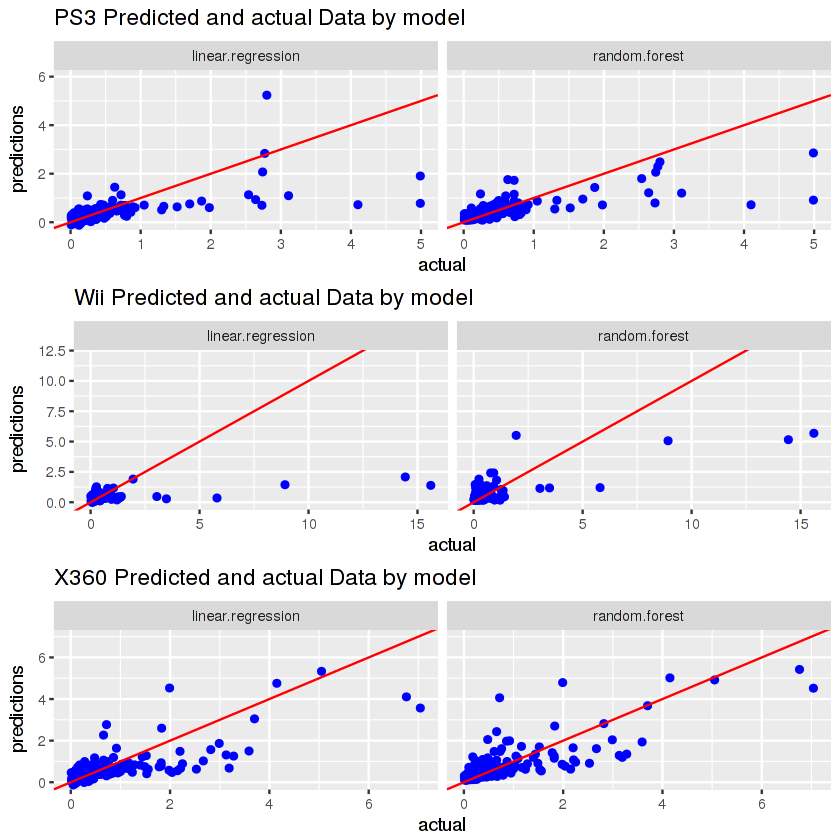

In [40]:
temp1 <- ggplot(data = ps3set.allpred,aes(x = actual, y = predictions)) + 
  geom_point(colour = "blue") + 
  geom_abline(intercept = 0, slope = 1, colour = "red") +
  facet_wrap(~ model,ncol = 2) + 
 coord_cartesian(ylim = c(0, 6)) +
  ggtitle("PS3 Predicted and actual Data by model")

temp2 <- ggplot(data = wiiset.allpred,aes(x = actual, y = predictions)) + 
  geom_point(colour = "blue") + 
  geom_abline(intercept = 0, slope = 1, colour = "red") +
  facet_wrap(~ model,ncol = 2) + 
 coord_cartesian(ylim = c(0, 12)) +
  ggtitle("Wii Predicted and actual Data by model")

temp3 <- ggplot(data = x360set.allpred,aes(x = actual, y = predictions)) + 
  geom_point(colour = "blue") + 
  geom_abline(intercept = 0, slope = 1, colour = "red") +
  facet_wrap(~ model,ncol = 2) + 
 coord_cartesian(ylim = c(0,7)) +
  ggtitle("X360 Predicted and actual Data by model")
grid.arrange(temp1, temp2, temp3, ncol=1)

Variable Importance
-------------------

Let's now have a look at the mse-importance of the rf-models

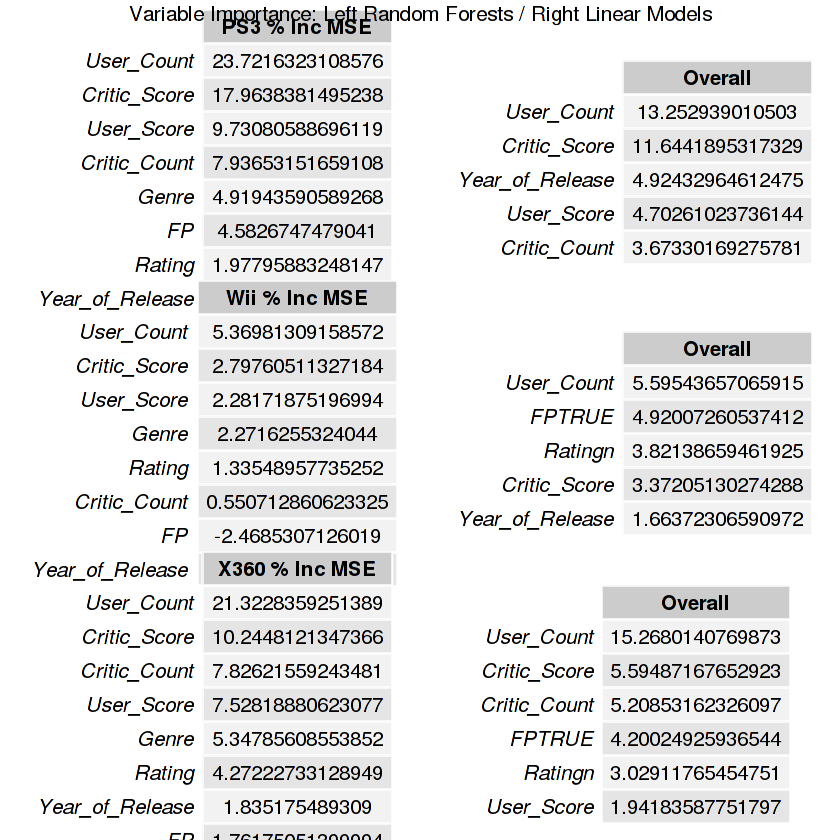

In [41]:
grid.arrange(tableGrob(ps3.rfimp),tableGrob(ps3.lmimp), 
             tableGrob(wii.rfimp), tableGrob(wii.lmimp), 
             tableGrob(x360.rfimp), tableGrob(x360.lmimp),
             top = "Variable Importance: Left Random Forests / Right Linear Models",
             ncol=2)

The relation between User_Count and NA_Sales is obvious.  Interestingly PS3 Games seems to benfit from Critic_score the most. Also Rating seems to have barely any effect on Sales with PS3 Games, whereas Wii  and X360 Games Sales suffer from Rating. Actually the Ps3 resembles my intuition about what should be the case the most.  
  
The Wii NA_Sales appear to be more randomly regarding these predictors. The lm model for the wii explains only ~35% of the variance contrasting ~55% for PS3 and X360.